# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
from copy import deepcopy
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from assembly import Assembly
from utils import load_yaml, num_params
from utils.models import load_model

In [3]:
sns.set(font_scale=1.25, style="whitegrid")

# Ignore known warnings that come when constructing subnets.
warnings.filterwarnings("ignore", message=".*The parameter 'pretrained' is deprecated.*")
warnings.filterwarnings("ignore", message=".*Arguments other than a weight enum.*")
warnings.filterwarnings("ignore", message=".*already erased node.*")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device = {device}")

NUM_CORES = os.cpu_count()
if hasattr(os, "sched_getaffinity"):
    # This function is only available on certain platforms. When running with Slurm, it can tell us the true
    # number of cores we have access to.
    NUM_CORES = len(os.sched_getaffinity(0))
print (f"Using {NUM_CORES} cores.")

Using 8 cores.


# Counting Compute

Figuring out how to count params and FLOPs, or whatever might be a good proxy for amount of compute.

In [34]:
from fvcore.nn import FlopCountAnalysis
from torchtnt.utils.flops import FlopTensorDispatchMode

def print_assembly_sizes(cfile):
    cfg = load_yaml(cfile)
    assembly = cfg.get("assembly", cfg.get("stages", cfg.get("src_stages")))
    model = Assembly(assembly, cfg.get("head"), input_shape=[3, 224, 224])
    print_sizes(model)


def print_sizes(model):
    model.train()
    print(f"Number of parameters: {num_params(model):.3e}")
    if hasattr(model, "parts"):
        for i, p in enumerate(model.parts):
            print(f"Num params in part {i+1} ({p.__class__.__name__}): {num_params(p):.3e}")

    dummy_img = torch.randn(1, 3, 224, 224)
    flops = FlopCountAnalysis(model, dummy_img)
    print(f"\nfvcore FLOPs: {flops.total():.3e}")
    # print(f"fvcore FLOPs by module: {flops.by_module()}")
    # print(f"fvcore FLOPs by operator: {flops.by_operator()}")
    with FlopTensorDispatchMode(model) as ftdm:
        _ = model(dummy_img)
        print(f"\nTorchTNT FLOPs: {sum(ftdm.flop_counts[''].values()):.3e}")
        # print(f"\nTorchTNT FLOPs breakdown:")
        # for k, v in ftdm.flop_counts.items():
        #     print(f"    {k}: {v:.3e}")

W1104 17:44:16.622000 42308 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [38]:
print_assembly_sizes(Path("../across-scales/mobilenet-v3.yml"))

Number of parameters: 5.483e+06
Num params in part 1 (Subnet): 4.368e+03
Num params in part 2 (Subnet): 4.440e+03
Num params in part 3 (Subnet): 1.033e+04
Num params in part 4 (Subnet): 4.198e+04
Num params in part 5 (Subnet): 3.208e+04
Num params in part 6 (Subnet): 6.993e+05
Num params in part 7 (Subnet): 4.292e+05
Num params in part 8 (Subnet): 4.261e+06

fvcore FLOPs: 2.386e+08

TorchTNT FLOPs: 2.166e+08


In [39]:
print_assembly_sizes(Path("../across-scales/resnet-50.yml"))

Number of parameters: 2.556e+07
Num params in part 1 (Subnet): 8.454e+04
Num params in part 2 (Subnet): 1.408e+05
Num params in part 3 (Subnet): 3.794e+05
Num params in part 4 (Subnet): 8.402e+05
Num params in part 5 (Subnet): 1.512e+06
Num params in part 6 (Subnet): 5.586e+06
Num params in part 7 (Subnet): 6.040e+06
Num params in part 8 (Subnet): 1.097e+07

fvcore FLOPs: 4.145e+09

TorchTNT FLOPs: 4.089e+09


In [40]:
print_assembly_sizes(Path("../across-scales/swin-t.yml"))

Number of parameters: 2.829e+07
Num params in part 1 (Subnet): 4.896e+03
Num params in part 2 (Subnet): 2.247e+05
Num params in part 3 (Subnet): 7.450e+04
Num params in part 4 (Subnet): 8.918e+05
Num params in part 5 (Subnet): 2.964e+05
Num params in part 6 (Subnet): 1.066e+07
Num params in part 7 (Subnet): 1.183e+06
Num params in part 8 (Subnet): 1.495e+07


parts.1.net.features.1.0.stochastic_depth



fvcore FLOPs: 4.509e+09

TorchTNT FLOPs: 4.491e+09


In [46]:
print_sizes(load_model("vit_small_patch16_224.augreg_in1k", "timm", pretrained=False))

blocks.0.attn.attn_drop, blocks.1.attn.attn_drop, blocks.10.attn.attn_drop, blocks.11.attn.attn_drop, blocks.2.attn.attn_drop, blocks.3.attn.attn_drop, blocks.4.attn.attn_drop, blocks.5.attn.attn_drop, blocks.6.attn.attn_drop, blocks.7.attn.attn_drop, blocks.8.attn.attn_drop, blocks.9.attn.attn_drop


Number of parameters: 2.205e+07

fvcore FLOPs: 4.251e+09

TorchTNT FLOPs: 4.241e+09


In [74]:
print_sizes(load_model("resnet18", "pytorch", pretrained=False))

Number of parameters: 1.169e+07

fvcore FLOPs: 1.827e+09

TorchTNT FLOPs: 1.814e+09


Below: demonstrating how the number of params and FLOPs in a ResNet BottleneckBlock are actually much smaller than a single conv3x3 layer.

In [58]:
# Assembly equivalent to a ResNet-50.
assembly_config = [
    {"Subnet": {
        "backend": "timm",
        "model_name": "resnet50.a1_in1k",
        "block_input": "x",
        "block_output": "layer2.3",
        "in_format": "img",  # layer1.0 input is [64, 56, 56].
        "out_format": ["img", [512, 28, 28]],
    }},
    {"Subnet": {  # Downsample block
        "backend": "timm",
        "model_name": "resnet50.a1_in1k",
        "block_input": "layer3.0",
        "block_output": "layer3.0",
        "in_format": ["img", [512, 28, 28]],
        "out_format": ["img", [1024, 14, 14]],
    }},
    {"Subnet": {
        "backend": "timm",
        "model_name": "resnet50.a1_in1k",
        "block_input": "layer3.1",
        "block_output": "fc",
        "in_format": ["img", [1024, 14, 14]],
        "out_format": "vector",
    }},
]

def newcfg():
    return deepcopy(assembly_config)


model = Assembly(newcfg(), input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.556e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (Subnet): 1.512e+06
Num params in part 3 (Subnet): 2.260e+07

fvcore FLOPs: 4.145e+09

TorchTNT FLOPs: 4.089e+09


In [59]:
from launch_scaling_experiments import linear, stitch, conv3x3, bottleneck, stitch_no_downsample

gap = {
    "blocks_to_drop": [1, 1],
    "num_downsamples": 1,
}

In [60]:
conv3x3_assembly = stitch(newcfg(), newcfg(), gap, conv3x3)
model = Assembly(conv3x3_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.877e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (SimpleAdapter): 4.723e+06
Num params in part 3 (Subnet): 2.260e+07

fvcore FLOPs: 4.696e+09

TorchTNT FLOPs: 4.642e+09


In [61]:
bottleneck_assembly = stitch(newcfg(), newcfg(), gap, bottleneck)
model = Assembly(bottleneck_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.556e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (ResNetBottleneck): 1.512e+06
Num params in part 3 (Subnet): 2.260e+07

fvcore FLOPs: 4.067e+09

TorchTNT FLOPs: 4.012e+09


In [62]:
bottleneck_no_downsample_assembly = stitch_no_downsample(newcfg(), newcfg(), gap, bottleneck)
model = Assembly(bottleneck_no_downsample_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.556e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (ResNetBottleneck): 1.512e+06
Num params in part 3 (Subnet): 2.260e+07



fvcore FLOPs: 1.070e+10

TorchTNT FLOPs: 1.060e+10


In [63]:
linear_assembly = stitch(newcfg(), newcfg(), gap, linear)
model = Assembly(linear_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.457e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (SimpleAdapter): 5.284e+05
Num params in part 3 (Subnet): 2.260e+07

fvcore FLOPs: 3.906e+09

TorchTNT FLOPs: 3.851e+09


In [64]:
linear_no_downsample_assembly = stitch_no_downsample(newcfg(), newcfg(), gap, linear)
model = Assembly(linear_no_downsample_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.457e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (SimpleAdapter): 5.284e+05
Num params in part 3 (Subnet): 2.260e+07



fvcore FLOPs: 1.111e+10

TorchTNT FLOPs: 1.102e+10


# Printing Model Computation Graph

A cell for inspecting the computation graph of a model.

In [35]:
import math
import timm
import torch
import torchvision
from torch import fx
from utils import num_params
from utils.subgraphs import _get_leaf_modules_for_ops, NodePathTracer

# We could load a model either from Torchvision or timm.
model = torchvision.models.swin_t()
# model = timm.create_model("mobilenetv3_large_100.ra_in1k")
# print(model)
tracer = NodePathTracer(autowrap_modules=(math, torchvision.ops), leaf_modules=_get_leaf_modules_for_ops())
graph = tracer.trace(model)
print_sizes(model)
# print(f"Number of parameters in graph: {num_params(fx.GraphModule(tracer.root, graph, model.__class__.__name__)):.3e}")

Number of parameters: 2.829e+07


features.1.0.attn.proj, features.1.0.attn.qkv, features.1.0.stochastic_depth, features.1.1.attn.proj, features.1.1.attn.qkv, features.3.0.attn.proj, features.3.0.attn.qkv, features.3.1.attn.proj, features.3.1.attn.qkv, features.5.0.attn.proj, features.5.0.attn.qkv, features.5.1.attn.proj, features.5.1.attn.qkv, features.5.2.attn.proj, features.5.2.attn.qkv, features.5.3.attn.proj, features.5.3.attn.qkv, features.5.4.attn.proj, features.5.4.attn.qkv, features.5.5.attn.proj, features.5.5.attn.qkv, features.7.0.attn.proj, features.7.0.attn.qkv, features.7.1.attn.proj, features.7.1.attn.qkv



fvcore FLOPs: 4.509e+09

TorchTNT FLOPs: 4.491e+09


In [36]:
print(graph)
# graph.print_tabular()

graph():
    %x : [num_users=1] = placeholder[target=x]
    %features_0_0 : [num_users=1] = call_module[target=features.0.0](args = (%x,), kwargs = {})
    %features_0_1 : [num_users=1] = call_module[target=features.0.1](args = (%features_0_0,), kwargs = {})
    %features_0_2 : [num_users=2] = call_module[target=features.0.2](args = (%features_0_1,), kwargs = {})
    %features_1_0_norm1 : [num_users=1] = call_module[target=features.1.0.norm1](args = (%features_0_2,), kwargs = {})
    %features_1_0_attn_relative_position_bias_table : [num_users=1] = get_attr[target=features.1.0.attn.relative_position_bias_table]
    %features_1_0_attn_relative_position_index : [num_users=1] = get_attr[target=features.1.0.attn.relative_position_index]
    %_get_relative_position_bias : [num_users=1] = call_function[target=torchvision.models.swin_transformer._get_relative_position_bias](args = (%features_1_0_attn_relative_position_bias_table, %features_1_0_attn_relative_position_index, [7, 7]), kwargs = {

In [37]:
for node, qualname in tracer.node_to_qualname.items():
    print(f"{qualname} --- {node}")

x --- x
features.0.0 --- features_0_0
features.0.1 --- features_0_1
features.0.2 --- features_0_2
features.1.0.norm1 --- features_1_0_norm1
features.1.0.attn.features_1_0_attn_relative_position_bias_table --- features_1_0_attn_relative_position_bias_table
features.1.0.attn._get_relative_position_bias --- _get_relative_position_bias
features.1.0.attn.features_1_0_attn_qkv_weight --- features_1_0_attn_qkv_weight
features.1.0.attn.features_1_0_attn_proj_weight --- features_1_0_attn_proj_weight
features.1.0.attn.features_1_0_attn_qkv_bias --- features_1_0_attn_qkv_bias
features.1.0.attn.features_1_0_attn_proj_bias --- features_1_0_attn_proj_bias
features.1.0.attn.shifted_window_attention --- shifted_window_attention
features.1.0.stochastic_depth --- features_1_0_stochastic_depth
features.1.0.add --- add
features.1.0.norm2 --- features_1_0_norm2
features.1.0.mlp --- features_1_0_mlp
features.1.0.stochastic_depth_1 --- features_1_0_stochastic_depth_1
features.1.0.add_1 --- add_1
features.1.1

In [9]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['aimv2_1b_patch14_224.apple_pt',
 'aimv2_1b_patch14_336.apple_pt',
 'aimv2_1b_patch14_448.apple_pt',
 'aimv2_3b_patch14_224.apple_pt',
 'aimv2_3b_patch14_336.apple_pt',
 'aimv2_3b_patch14_448.apple_pt',
 'aimv2_huge_patch14_224.apple_pt',
 'aimv2_huge_patch14_336.apple_pt',
 'aimv2_huge_patch14_448.apple_pt',
 'aimv2_large_patch14_224.apple_pt',
 'aimv2_large_patch14_224.apple_pt_dist',
 'aimv2_large_patch14_336.apple_pt',
 'aimv2_large_patch14_336.apple_pt_dist',
 'aimv2_large_patch14_448.apple_pt',
 'bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patc

# Dataset Testing

In [38]:
import torchvision

# sun_dataset = torchvision.datasets.SUN397("data/SUN397", download=True)
# scars_dataset = torchvision.datasets.StanfordCars("../data", split="train")
sst2_dataset = torchvision.datasets.RenderedSST2("../data", split="train", download=True)

100%|██████████| 138M/138M [00:18<00:00, 7.46MB/s] 


Extracting ../data/rendered-sst2.tgz to ../data


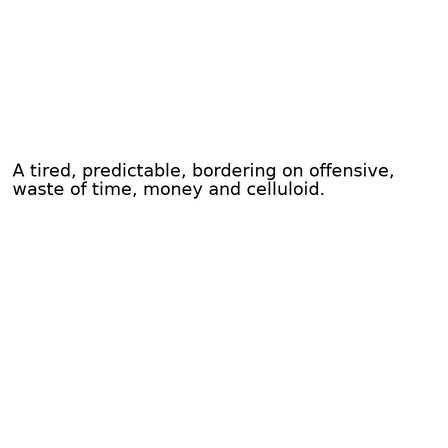

In [42]:
sst2_dataset[1][0]

In [23]:
import open_clip
model, train_transforms, val_transforms = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")

[autoreload of sympy.core.parameters failed: Traceback (most recent call last):
  File "/Users/ntraft/miniconda3/envs/stitch/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ntraft/miniconda3/envs/stitch/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/ntraft/miniconda3/envs/stitch/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/ntraft/miniconda3/envs/stitch/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/ntraft/miniconda3/envs/stitch/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to _global_parameters object
]


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/Users/ntraft/miniconda3/envs/stitch/lib/python3.11/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [29]:
train_transforms

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic, antialias=True)
    <function _convert_to_rgb at 0x15cd202c0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [32]:
import torchvision
torchvision.transforms.RandomResizedCrop(224)

RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)